In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from IC.importer import *
from IC.processer import *
from IC.event_processing import normalize_bin_by_bin, count_plots
from IC.main import sim_events, list_of_params, ic_params
from functions import perform_chisq
from scipy.stats import chi2
import pickle
from src.plotter import savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath, siunitx}')
np.set_printoptions(linewidth=200)

IC_observed_full = np.array(get_IC_data().T)
E_rate, z_rate = get_flux_factor()
flux_E_factors_full, flux_z_factors_full = bin_flux_factors(E_rate,z_rate)
EFrom,ETo,zFrom,zTo = 0,13,0,20
z_bins = np.arange(zFrom,zTo)
E_bins, z_bins_T = np.arange(EFrom,ETo), np.arange(zFrom,zTo)[:,None]
n_Ebins, n_zbins = len(E_bins), len(z_bins)
flux_E_factors = flux_E_factors_full[E_bins]
flux_z_factors = flux_z_factors_full[z_bins]
flux_factors = np.outer(flux_E_factors, flux_z_factors)
IC_observed = IC_observed_full[E_bins,z_bins_T].T
#IC_observed_2017 = np.array(pd.read_csv('./pre_computed/IC_observed_2017.csv', header=None))

In [2]:
giunti_contour_cl90 = pd.read_csv('./src/data/files/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./src/data/files/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./src/data/files/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./src/data/files/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')

E_ratios_full = pd.read_csv('./src/data/files/E_ratios.csv', header=None, names=['Ereco', 'Eratio']).Eratio.values
z_ratios_full = pd.read_csv('./src/data/files/z_ratios.csv', header=None, names=['zreco', 'zratio']).zratio.values
IC_per_z_full = np.array(np.sum(IC_observed_full, axis=0))
IC_per_E_full = np.array(np.sum(IC_observed_full, axis=1))
MC_per_E_full = (IC_per_E_full/E_ratios_full)
MC_per_z_full = (IC_per_z_full/z_ratios_full)

MC_ratios_full = np.outer(E_ratios_full, z_ratios_full)
IC_MC_full = IC_observed_full / MC_ratios_full
IC_MC = IC_MC_full[EFrom:ETo+1,z_bins]
#IC_MC_2017 = np.load('./pre_computed/IC_MC.npy')[E_bins,z_bins_T].T #Dont use this

Ereco_full = 500*10**np.linspace(0.0,1.3,14)
Ereco_full_midpoints = Ereco_full[0:-1] +np.diff(Ereco_full)/2 #For scatter plot

Ereco = Ereco_full[EFrom:ETo+1]
Ereco_midpoints= Ereco_full_midpoints[3:14]

zreco_full = np.linspace(-1,0,21)
zreco_full_midpoints = zreco_full[0:-1] +np.diff(zreco_full)/2 #For scatter plot

zreco = zreco_full[zFrom:zTo+1]
zreco_midpoints = zreco_full_midpoints[z_bins]

In [3]:
ndim = 4
N = 13
alpha = 0.99
dm41From = 0.01
dm41To = 10
dm41N = 10
s24From = 0.01
s24To = 1
s24N = 10
dm41_range = np.logspace(np.log10(dm41From), np.log10(dm41To),dm41N)
s24_range = np.linspace(s24From,s24To,s24N)
param_list = list_of_params(ic_params, dm41_range, s24_range)
print(dm41_range)
print(s24_range)

[ 0.01   0.022  0.046  0.1    0.215  0.464  1.     2.154  4.642 10.   ]
[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]


In [4]:
H1_events_list = pickle.load(open(f'./pre_computed/H1_IC_N{N}_{len(dm41_range)}x{len(s24_range)}.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_new.p','rb'))

In [5]:
H1_events_list = np.array(H1_events_list).reshape(100,13,20)
H0_events = H0_events[0,:,:]

In [6]:
gamma = 0.3
delta_T = 0#(np.sum(sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma])) - np.sum(H0_events))/np.sum(H0_events)

In [7]:
norm_factors = normalize_bin_by_bin(H0_events[:,z_bins],MC=True)
H0_normalized = norm_factors *H0_events[:,z_bins]
H1_list_normalized = [norm_factors*H1[:,z_bins] for H1 in H1_events_list]

In [9]:
s24_cl90_index_list=[]
s24_cl99_index_list=[]
dm41_cl90_index_list=[]
dm41_cl99_index_list=[]
x0 = [1., 0.]

sigma_a = 0.24
sigma_b = 0.04
sigma_g = delta_T
f = 0.25
sigma_syst = f*IC_observed

#chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
chisq_H1_list  = np.array([perform_chisq(H1_norm, IC_observed,sigma_syst=sigma_syst,z=zreco, sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)[0] for H1_norm in H1_list_normalized])
delta_chi = chisq_H1_list - np.min(chisq_H1_list)#chisq_H1_list - chisq_H0

best_fit_index = np.argmin(delta_chi)
best_fit_params = param_list[best_fit_index]
best_fit_events = H1_list_normalized[best_fit_index]
_, best_a =perform_chisq(H1_list_normalized[best_fit_index], IC_observed,sigma_syst=sigma_syst,z=zreco,sigma_a=sigma_a, sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)
p_value = chi2.sf(np.min(chisq_H1_list),2)

if len(best_a) == 2:
    a = best_a[0]
    b = best_a[1]
    H1_best = a*(1+b*(0.5+zreco[0:-1]))*best_fit_events
elif len(best_a) == 1:
    H1_best = best_a*best_fit_events


deltachi_reshaped = delta_chi.reshape(len(dm41_range), len(s24_range))
'''
cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)
cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)

s24_cl90_index = get_boundary(cl_90_bool)
dm41_cl90_index = np.linspace(0,len(s24_cl90_index)-1,len(s24_cl90_index)).astype('int')
s24_cl99_index = get_boundary(cl_99_bool)
dm41_cl99_index = np.linspace(0,len(s24_cl99_index)-1,len(s24_cl99_index)).astype('int')

s24_cl90_index_list.append(s24_cl90_index)
s24_cl99_index_list.append(s24_cl99_index)
dm41_cl90_index_list.append(dm41_cl90_index)
dm41_cl99_index_list.append(dm41_cl99_index)
'''

"\ncl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)\ncl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)\n\ns24_cl90_index = get_boundary(cl_90_bool)\ndm41_cl90_index = np.linspace(0,len(s24_cl90_index)-1,len(s24_cl90_index)).astype('int')\ns24_cl99_index = get_boundary(cl_99_bool)\ndm41_cl99_index = np.linspace(0,len(s24_cl99_index)-1,len(s24_cl99_index)).astype('int')\n\ns24_cl90_index_list.append(s24_cl90_index)\ns24_cl99_index_list.append(s24_cl99_index)\ndm41_cl90_index_list.append(dm41_cl90_index)\ndm41_cl99_index_list.append(dm41_cl99_index)\n"

In [14]:
best_fit_params

{'theta_12': 0.5837630475986898,
 'theta_13': 0.15494769630192953,
 'theta_23': 0.7695841386786632,
 'theta_34': 0,
 'theta_24': 0.4794283060805146,
 'theta_14': 0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.53e-05,
 'dm_31': 0.0025153,
 'dm_41': 0.01}

In [17]:
np.sin(2*best_fit_params['theta_24'])**2, best_fit_params['theta_24']*180/np.pi

(0.6700000000000002, 27.46921851751971)

In [10]:
from scipy.interpolate import RectBivariateSpline
dm41_fine = np.logspace(np.log10(dm41From),np.log10(dm41To),49)
s24_fine = np.linspace(s24From,s24To,49)

spl = RectBivariateSpline(s24_range,dm41_range,deltachi_reshaped)


z = spl(s24_fine,dm41_fine)

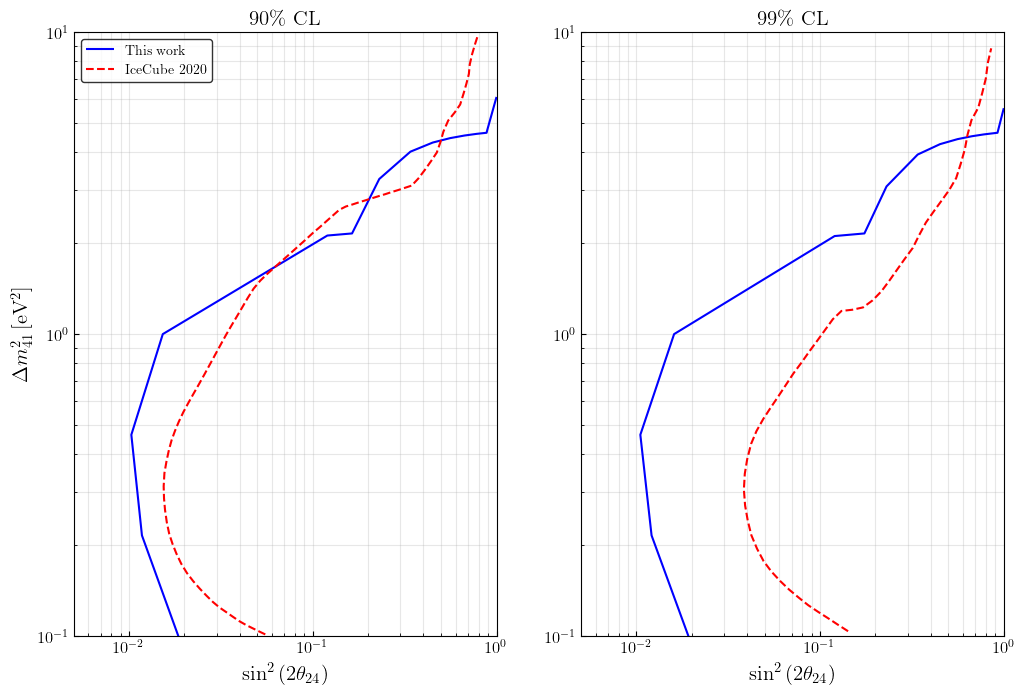

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,8))

#ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label=r'Giunti et al.')
a = ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
#ax[0].plot(s24_range[s24_cl90_index_list], dm41_range[dm41_cl90_index_list[0]], label='Norm')
cnt = ax[0].contour(s24_range, np.flip(dm41_range), deltachi_reshaped, levels=[chi2.cdf(0.9,2)], colors=['blue'])
#ax[0].contour(s24_fine, np.flip(dm41_fine), z, levels=[chi2.cdf(0.9,2)])

#ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al.',ls='solid')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].contour(s24_range, np.flip(dm41_range), deltachi_reshaped, levels=[chi2.cdf(0.99,2)], colors=['blue'])
#ax[1].plot(s24_range[s24_cl99_index_list[0]], dm41_range[dm41_cl99_index_list[0]], label='Norm')



ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,1e1))
ax[1].set_ylim((1e-1,1e1))
ax[0].set_xlabel(r'$\sin^2{(2\theta_{24})}$', fontsize=15)
ax[1].set_xlabel(r'$\sin^2{(2\theta_{24})}$', fontsize=15)
ax[0].set_ylabel(r'$\Delta m^2_{41} \, [\si{\eV\squared}]$', fontsize=15)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title(r'$90\%$ $\mathrm{CL}$', fontsize=15)
ax[1].set_title(r'$99\%$ $\mathrm{CL}$', fontsize=15)


ax[0].tick_params(axis='both', direction='in', which='both', labelsize=12)
ax[1].tick_params(axis='both', direction='in', which='both', labelsize=12)

h1,_ = cnt.legend_elements()
leg = ax[0].legend([h1[0], a[0]], ['This work', 'IceCube 2020'])
leg.get_frame().set_edgecolor('k')
#savethesis(fig, 's24_contour')

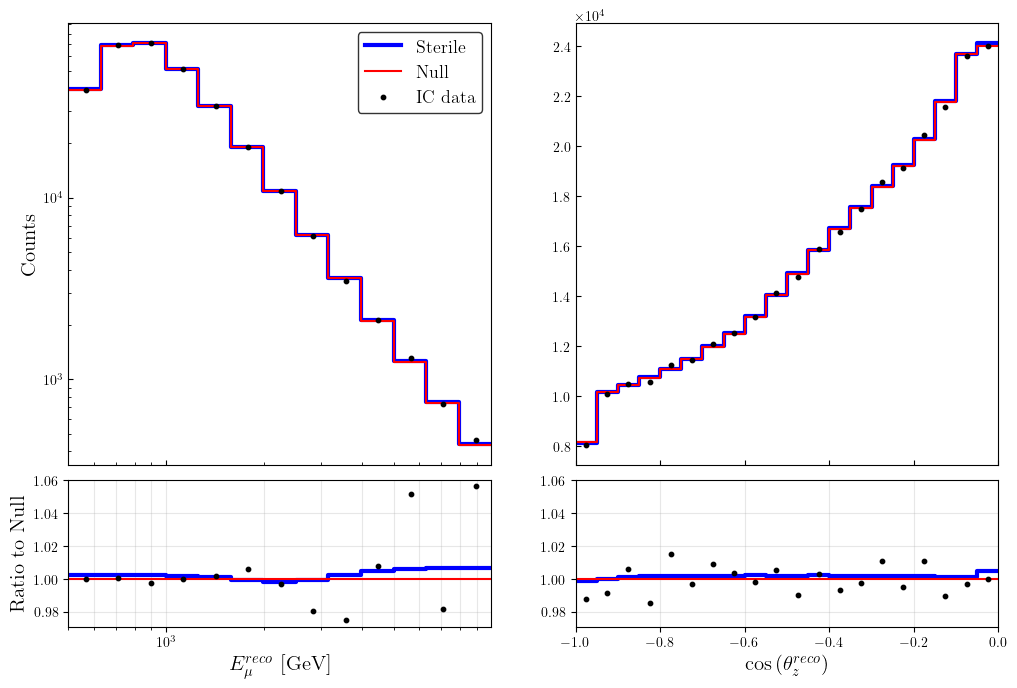

In [13]:
from IC.event_processing import count_plots
fig = count_plots(H1_best,H0_normalized)
savethesis(fig, 'final_rate_plot')

In [51]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
temp_params = list_of_params(ic_params, np.array([0.5]), np.array([0.02]), np.array([0,0.02]))
Pam = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)
Pm = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pe = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pae = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)

Pamam = Pam[:,1]
Pmm = Pm[:,1]
Pem = Pe[:,1]
Paeam = Pae[:,1]

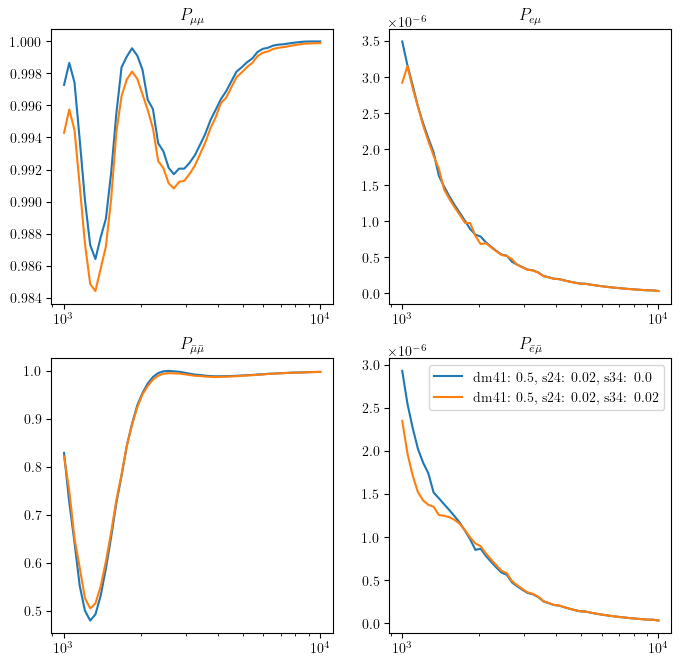

In [52]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
for i,prob in enumerate(Pmm):
    ax[0].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pem):
    ax[1].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pamam):
    ax[2].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Paeam):
    ax[3].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[3].set_title('$P_{\\bar{e}\\bar{\mu}}$')
plt.legend()